# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import warnings
warnings.filterwarnings('ignore')

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [ ]:
def Q1(num_examples=5):
    ### STUDENT START ###
    # For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).
    for label, text in zip(newsgroups_train.target[:num_examples],newsgroups_train.data[:num_examples]):
        l = "\033[1m" + "Label: " + "\033[0m"
        t = "\033[1m" + "Text: " + "\033[0m\n"
        print(f"{l}{categories[label]}\n{t} {text} \n") # TODO: fix bolding headers on print out
    ### STUDENT END ###

Q1(5)

Label: talk.religion.misc
Text: 
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

Label: sci.space
Text: 
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [ ]:
def Q2():
    ### STUDENT START ###
    # This will be used to highlight the answers to the questions
    ans = lambda x: "\x1b[1;30;43m" + str(x) + "\x1b[0m"

    # 1. Transform the training data into a matrix of word unigram feature vectors.
    print('1. Transform the training data into a matrix of word unigram feature vectors.')
    v = CountVectorizer()
    train = v.fit_transform(train_data)
    size1 = train.shape[1]
    #     1. What is the size of the vocabulary?
    print('     1. What is the size of the vocabulary? ', ans(size1))

    #     2. What is the average number of non-zero features per example?
    avg = float(train.nnz)/train.shape[0]
    print('     2. What is the average number of non-zero features per example?', ans(avg))

    #     3. What is the fraction of the non-zero entries in the matrix?
    fraction = float(train.nnz)/(train.shape[0] * train.shape[1])
    print('     3. What is the fraction of the non-zero entries in the matrix?', ans(fraction))

    #     4. What are the 0th and last feature strings (in alphabetical order)?
    print('     4. What are the 0th and last feature strings (in alphabetical order)?', '{0th: ', ans(v.get_feature_names()[0]),' last: ', ans(v.get_feature_names()[-1]),'}')


    #         Use CountVectorization and its .fit_transform method. Use .nnz and .shape attributes, and .get_feature_names method.
    
    # 2. Now transform the training data into a matrix of word unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the size of the vocabulary.
    print('2. Now transform the training data into a matrix of word unigram feature vectors restricting to ')
    print('   the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].')
    v2 = CountVectorizer(vocabulary= ["atheism", "graphics", "space", "religion"])      
    train2 = v2.fit_transform(train_data)           
    print('     Confirm the size of the vocabulary.', ans(train2.shape[1]))

    #     1. What is the average number of non-zero features per example?
    #         Use CountVectorization(vocabulary=...) and its .transform method.
    avg2 = float(train2.nnz)/train2.shape[0]
    print('     1. What is the average number of non-zero features per example?', ans(avg2))

    # 3. Now transform the training data into a matrix of character bigram and trigram feature vectors.
    print('3. Now transform the training data into a matrix of character bigram and trigram feature vectors.')
    v3 = CountVectorizer(analyzer="char", ngram_range=(2,3))    
    train3 = v3.fit_transform(train_data)
    
    #     1. What is the size of the vocabulary?
    #         Use CountVectorization(analyzer=..., ngram_range=...) and its .fit_transform method.
    print('     1. What is the size of the vocabulary?', ans(train3.shape[1]))

    # 4. Now transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents.
    print('4. Now transform the training data into a matrix of word unigram feature vectors and prune words that appear ')
    print('   in fewer than 10 documents.')
    v4 = CountVectorizer(min_df=10)    
    train4 = v4.fit_transform(train_data)
    #     1. What is the size of the vocabulary?
    #         Use CountVectorization(min_df=...) and its .fit_transform method.
    print('     1. What is the size of the vocabulary?', ans(train4.shape[1]))

    # 5. Now again transform the training data into a matrix of word unigram feature vectors.
    #     1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
    #         Hint: Build vocabularies for both train and dev and look at the size of the difference.
    
    print('5. Now again transform the training data into a matrix of word unigram feature vectors.')
    print('     1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?')
    v5 =  CountVectorizer()
    train5 = v5.fit_transform(dev_data)
    size5 = train5.shape[1]
    s = len(set(v5.get_feature_names()).difference(v.get_feature_names()))   
    print(f'The fraction of words in the development vocabulary that is missing from the training vocabulary: {ans(float(s)/size5)} of dev size or {ans(float(s)/size1)} of training size')

    ### STUDENT END ###

Q2()

1. Transform the training data into a matrix of word unigram feature vectors.
     1. What is the size of the vocabulary?  26879
     2. What is the average number of non-zero features per example? 96.70599803343165
     3. What is the fraction of the non-zero entries in the matrix? 0.0035978272269590263
     4. What are the 0th and last feature strings (in alphabetical order)? {0th:  00  last:  zyxel }
2. Now transform the training data into a matrix of word unigram feature vectors restricting to 
   the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].
     Confirm the size of the vocabulary. 4
     1. What is the average number of non-zero features per example? 0.26843657817109146
3. Now transform the training data into a matrix of character bigram and trigram feature vectors.
     1. What is the size of the vocabulary? 35478
4. Now transform the training data into a matrix of word unigram feature vectors and prune words that appear 
   in fewer than 10 do

### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [ ]:
def Q3():
    ### STUDENT START ###
    # 1. Transform the training and development data to matrices of word unigram feature vectors.
    print('1. Transform the training and development data to matrices of word unigram feature vectors.')
    cv = CountVectorizer()
    train = cv.fit_transform(train_data)
    dev = cv.transform(dev_data)

    # 2. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. For each model, show the k value and f1 score.
    print('\n2. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. ')
    print('     For each model, show the k value and f1 score.\n')
    i, j = 0, 1
    df1 = pd.DataFrame(columns = ['k', 'f1-score', 'best'])    
    for k in range(1,5):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(train, train_labels)
      pmodel = knn.predict(dev)
      f1 = metrics.f1_score(dev_labels, pmodel, average="weighted")      
      df1 = df1.append({'k': k, 'f1-score': f1, 'best': False}, ignore_index=True)

    df1.loc[df1['f1-score'] == df1['f1-score'].max(), 'best'] = True
    print(df1)
    
    # 3. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score. For each model, show the alpha value and f1 score.
    print('\n3. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize ')
    print('     f1 score. For each model, show the alpha value and f1 score.\n')
    i, j = 0, 1
    alphas = [0] + [(0.00001 * 10**i) for i in range(0,6)] # BernoulliNB Alphas Parameters
    df2 = pd.DataFrame(columns = ['alpha', 'f1-score', 'best'])
    for a in range(0,len(alphas)):
      bnb = BernoulliNB(alpha=alphas[a])
      bnb.fit(train, train_labels)
      pmodel = bnb.predict(dev)
      f1 = metrics.f1_score(dev_labels, pmodel, average="weighted")     
      df2 = df2.append({'alpha': float(alphas[a]), 'f1-score': f1, 'best': False}, ignore_index=True)

    df2.loc[df2['f1-score'] == df2['f1-score'].max(), 'best'] = True      
    print(df2)

    # 4. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score. For each model, show the C value, f1 score, and sum of squared weights for each topic.
    print('\n4. Produce several Logistic Regression models by varying L2 regularization strength (C), ')
    print('     including one with C set approximately to optimize f1 score. For each model, show the C value, f1 score, ')
    print('     and sum of squared weights for each topic.\n')
    i, j = 0, 1
    C = [(.1 * i) for i in range(1,11)] # Regularization Parameter
    df3 = pd.DataFrame(columns = ['C', 'f1-score', 'sum of squared weights', 'best'])
    for n in range(0,len(C)):
      lr = LogisticRegression(C=C[n], solver="liblinear", multi_class="auto")
      lr.fit(train,train_labels)
      pmodel = lr.predict(dev)
      f1 = metrics.f1_score(dev_labels, pmodel, average="weighted")     
      df3 = df3.append({'C': n , 'f1-score': f1, 'sum of squared weights': np.sum(lr.coef_**2), 'best': False}, ignore_index=True)

    df3.loc[df3['f1-score'] == df3['f1-score'].max(), 'best'] = True        
    print(df3)
    # 5. Why doesn't k-Nearest Neighbors work well for this problem? 
    print("\n5. Why doesn't k-Nearest Neighbors work well for this problem?")
    print('\n   The frequency and diversity peripheral words that are less relevant convolute the accuracy of the classification. ')
    print('   KNN can be used on N-gram problems, however it is more difficult to achieve the accuracy compared to Naive Bayes or Logistic Regression.')
    
    # 6. Why doesn't Logistic Regression work as well as Naive Bayes does?
    print("\n6. Why doesn't Logistic Regression work as well as Naive Bayes does?")
    print('\n   Logistic Regression is impacted by less relevant words compared to Navie Bayes, however we did get a better f1-score with LR vs NB.')

    # 7. What is the relationship between logistic regression's sum of squared weights vs. C value?
    print("\n7. What is the relationship between logistic regression's sum of squared weights vs. C value?")
    print('\n   The sum of squared weights increase with C values. Smaller C values specify a stronger regularization and greater values are less regularized and therefor increase the variance of the model.')

    ### STUDENT END ###

Q3()

1. Transform the training and development data to matrices of word unigram feature vectors.

2. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. 
     For each model, show the k value and f1 score.

   k  f1-score   best
0  1  0.380503  False
1  2  0.380542  False
2  3  0.408415   True
3  4  0.403123  False

3. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize 
     f1 score. For each model, show the alpha value and f1 score.

     alpha  f1-score   best
0  0.00000  0.700797   True
1  0.00001  0.687847  False
2  0.00010  0.685559  False
3  0.00100  0.681411  False
4  0.01000  0.660963  False
5  0.10000  0.626680  False
6  1.00000  0.544477  False

4. Produce several Logistic Regression models by varying L2 regularization strength (C), 
     including one with C set approximately to optimize f1 score. For each model, show the C value, f1 score, 
     and sum of squ

ANSWER: 

**5. Why doesn't k-Nearest Neighbors work well for this problem?**

   The frequency and diversity peripheral words that are less relevant convolute the accuracy of the classification. KNN can be used on N-gram problems, however it is more difficult to achieve the accuracy compared to Naive Bayes or Logistic Regression. 

**6. Why doesn't Logistic Regression work as well as Naive Bayes does?**
   
   Logistic Regression is impacted by less relevant words compared to Navie Bayes, however we did get a better f1-score with LR vs NB. 

**7. What is the relationship between logistic regression's sum of squared weights vs. C value?** 
   
   The sum of squared weights increase with C values. Smaller C values specify a stronger regularization and greater values are less regularized and therefor increase the variance of the model.

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


1. Transform the data to a matrix of word bigram feature vectors. Produce a Logistic Regression model.
2. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
   Number of rows: 4
   Number of cols: 5
3. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.


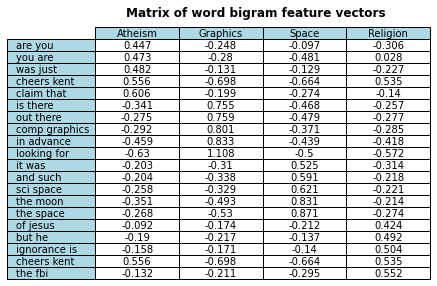

4. Do you see any surprising features in this table?
    The features in the table not contextually as meaningful and are predominatly stop words. We also have "cheers kent" twice.


In [ ]:
def Q4():
    ### STUDENT START ###
    
    # 1. Transform the data to a matrix of word bigram feature vectors. Produce a Logistic Regression model.
    print('1. Transform the data to a matrix of word bigram feature vectors. Produce a Logistic Regression model.')
    v = CountVectorizer(analyzer="word", ngram_range=(2,2))
    train = v.fit_transform(train_data)
    words = v.get_feature_names()

    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(train, train_labels)

    # 2. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
    print('2. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.')
    c = np.argsort(lr.coef_)[:,-5:]
    
    print('   Number of rows:', c.shape[0])
    print('   Number of cols:', c.shape[1])
    # values
    v = [lr.coef_[:,c[i][j]] for i in range(c.shape[0]) for j in range(c.shape[1])]
    # features
    f = [words[c[i][j]] for i in range(c.shape[0]) for j in range(c.shape[1])]

    # 3. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
    print('3. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.')
    fig, ax =plt.subplots()
    ax.set_axis_off() 
    table = ax.table( 
        cellText = np.around(np.array(v),decimals=3),  
        rowLabels = f,   
        colLabels = ('Atheism', 'Graphics', 'Space', 'Religion'), 
        rowColours =["lightblue"] * 20,  
        colColours =["lightblue"] * 20, 
        cellLoc ='center',  
        loc ='upper left')   
      
    ax.set_title('Matrix of word bigram feature vectors', fontweight ="bold") 
    plt.show()

    # 4. Do you see any surprising features in this table?
    print('4. Do you see any surprising features in this table?')
    print('    The features in the table not contextually as meaningful and are predominatly stop words. We also have "cheers kent" twice.')

    ### STUDENT END ###

Q4()

ANSWER: 
4. Do you see any surprising features in this table?
   
   The features in the table not contextually as meaningful and are predominatly paired stop words. We also have "cheers kent" twice.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [ ]:
def preprocessor(x):

    x = x.lower()
    for pattern, repl in [('\n', ' ')               # New line character
                        , ('\s+', ' ')              # Multiple whitespace
                        , (r"[^A-Za-z0-9_\s]", ' ') # Punctuation
                        , ('(ing |ings )', ' ') 
                        , ('s ', ' ')               # Words ending in 's'
                        , ('(but|and|no|child|internet|email) ', ' ') # Using online word counts to find
                        , ('ment ', 'e ')
                         ]:  
      x = re.sub(pattern, repl, x) 
    return x
    
def Q5():
    ### STUDENT START ###
    # This will be used to highlight the answers to the questions
    ans = lambda x: "\x1b[1;30;43m" + str(x) + "\x1b[0m"
    # This will be used as a preprocessor for the imporved model
    #preprocessor = lambda x: x

    # 1. Produce a Logistic Regression model (with no preprocessing of text). Note that you may need to override the "default" preprocessing with an identity function. Evaluate and show its f1 score and size of the dictionary.
    print('1. Produce a Logistic Regression model (with no preprocessing of text). Note that you may need to override the "default" preprocessing with an identity function. ')
    print('   Evaluate and show its f1 score and size of the dictionary.')
    v = CountVectorizer()
    train = v.fit_transform(train_data)
    dev = v.transform(dev_data)
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(train,train_labels)
    pmodel = model.predict(dev)
    f1_1 = metrics.f1_score(dev_labels, pmodel, average="weighted")
    print("     The size of the vocabulary is: " + ans(train.shape[1]))
    print("     The f1-score is: " + ans(f1_1))

    # 2. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary. Aim for an improvement in f1 score of 0.02. Note: this is actually very hard.
    print('2. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.')
    print('   Aim for an improvement in f1 score of 0.02. Note: this is actually very hard.')
    v2 = CountVectorizer(preprocessor=preprocessor)
    train2 = v2.fit_transform(train_data)
    dev2 = v2.transform(dev_data)
    model.fit(train2, train_labels)
    pmodel2 = model.predict(dev2)
    f1_2 = metrics.f1_score(dev_labels, pmodel2, average='weighted')
    print("     The size of the vocabulary is: " + ans(train2.shape[1]))
    print("     The f1-score is: " + ans(f1_2))

    # 3. How much did the improved model reduce the vocabulary size?
    print('3. How much did the improved model reduce the vocabulary size?')   
    print('   Reduce size by ', ans(train.shape[1] - train2.shape[1]), ' with f1-score improvement of ', ans(np.round(f1_2 - f1_1, 3)))

    ### STUDENT END ###

Q5()

1. Produce a Logistic Regression model (with no preprocessing of text). Note that you may need to override the "default" preprocessing with an identity function. 
   Evaluate and show its f1 score and size of the dictionary.
     The size of the vocabulary is: 26879
     The f1-score is: 0.7084739776490449
2. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.
   Aim for an improvement in f1 score of 0.02. Note: this is actually very hard.
     The size of the vocabulary is: 23452
     The f1-score is: 0.7300525288597499
3. How much did the improved model reduce the vocabulary size?
   Reduce size by  3427  with f1-score improvement of  0.022


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

1. For several L1 regularization strengths ...
     1. Produce a Logistic Regression model using the L1 regularization strength. 
        Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
     2. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an L2 regularization strength of 0.5.
     3. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
   LR1 regularization strength  vocabulary size  ...  LR2 f1-score  size (log)
0                          0.3            531.0  ...      0.674333    6.274762
1                          0.4            661.0  ...      0.677996    6.493754
2                          0.5            765.0  ...      0.659712    6.639876
3                          0.6            867.0  ...      0.670258    6.765039
4                          0.7            931.0  ...      0.675524    6.836259
5                

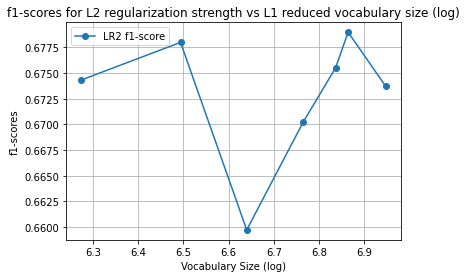


3. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

   The performance of the model doens't seem to improve with increasing regularization


In [ ]:
def Q6():
    # Keep this random seed here to make comparison easier.
    seed = np.random.seed(0)
    
    ### STUDENT START ###

    print('1. For several L1 regularization strengths ...')
    C = [.1 * i for i in range(3,10)] # Regularization parameter
    
    v = CountVectorizer()
    train1 = v.fit_transform(train_data)
    dev1 = v.transform(dev_data)
    
    df = pd.DataFrame(columns = ['LR1 regularization strength', 'vocabulary size', 'LR1 f1-score', 'LR2 f1-score', 'size (log)'])
    for i, c in enumerate(C):
      
      #     1. Produce a Logistic Regression model using the L1 regularization strength. Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
      if i == 1: 
        print('     1. Produce a Logistic Regression model using the L1 regularization strength. ')    
        print('        Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.')  

      lr1 = LogisticRegression(penalty="l1", tol=0.015, C=c, random_state=seed, solver="liblinear")
      lr1.fit(train1,train_labels)
      pmodel1 = lr1.predict(dev1)
      f1_1 = metrics.f1_score(dev_labels, pmodel1, average="weighted")

      #     2. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an L2 regularization strength of 0.5.
      if i == 1:
        print('     2. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an L2 regularization strength of 0.5.')
    
      r = [v.get_feature_names()[j] for j, k in enumerate(np.count_nonzero(lr1.coef_, axis=0)) if k > 0]

      v2 = CountVectorizer(vocabulary=r)
      train2 = v2.fit_transform(train_data)
      dev2 = v2.transform(dev_data)

      lr2 = LogisticRegression(tol=0.015, C=0.5, random_state=seed, solver="liblinear")
      lr2.fit(train2, train_labels)
      pmodel2 = lr2.predict(dev2)
      f1_2 = metrics.f1_score(dev_labels, pmodel2, average="weighted")
      
      #     3. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
      if i == 1:
        print('     3. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.')
    
      df = df.append({'LR1 regularization strength': c , 'vocabulary size': len(r), 'LR1 f1-score': f1_1, 'LR2 f1-score': f1_2, 'size (log)': np.log(len(r))}, ignore_index=True)

    print(df)

    # 2. Show a plot of f1 score vs. log vocabulary size. Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
    print('\n2. Show a plot of f1 score vs. log vocabulary size. Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.')
    df.plot(x = 'size (log)'
          , y = 'LR2 f1-score'
          , kind='line'
          , xlabel='Vocabulary Size (log)'
          , ylabel='f1-scores'
          , title='f1-scores for L2 regularization strength vs L1 reduced vocabulary size (log)'
          , marker='o')
    plt.grid(True)
    plt.show() 

    # 3. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?
    print('\n3. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?')
    print("\n   The performance of the model doens't seem to improve with increasing regularization")
    ### STUDENT END ###

Q6()

ANSWER: 

**3. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?**

The performance of the model doens't seem to improve with increasing regularization


### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [90]:
def Q7():
    ### STUDENT START ###
    
    # This will be used to highlight the answers to the questions
    ans = lambda x: "\x1b[1;30;43m" + str(x) + "\x1b[0m"

    # 1. How is TfidfVectorizer different than CountVectorizer?
    print('1. How is TfidfVectorizer different than CountVectorizer?')
    print('   Both returns a matrix of token counts, the TfidfVectorizer values are floats and CountVectorizer values are integers')

    v1 = CountVectorizer()
    train1 = v1.fit_transform(train_data)
    dev1 = v1.transform(dev_data)
    lr1 = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr1.fit(train1, train_labels)
    pmodel1 = lr1.predict(dev1)
    f1_1 =  metrics.f1_score(dev_labels, pmodel1, average="weighted")
    print('\n    CountVectorizer f1-score: ', ans(f1_1))

    v2 = TfidfVectorizer()
    train2 = v2.fit_transform(train_data)
    dev2 = v2.transform(dev_data)    
    lr2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr2.fit(train2, train_labels)
    pmodel2 = lr2.predict(dev2)
    f1_2 = metrics.f1_score(dev_labels, pmodel2, average="weighted")
    print('    TfidfVectorizer f1-score: ', ans(f1_2))

    # 2. Show the 3 documents with highest R ratio, where ...
    #     Rratio=maximumpredictedprobability÷predictedprobabilityofcorrectlabel 
    print('\n2. Show the 3 documents with highest R ratio, where ...')
    print('    Rratio=maximumpredictedprobability÷predictedprobabilityofcorrectlabel ')
    pmodel = lr2.predict_proba(dev2)
    pmodel_max = np.max(pmodel)
    
    d = {i: pmodel_max / pmodel[i, dev_labels[i]] for i in range(len(dev_labels))}
    d = sorted(d.items(),key= lambda x:x[1], reverse=True)
    print('    highest R ratio ', ans([r for idx, r in d[:3]]))
    print("\x1b[1m" + '\n    highest R data values' + "\x1b[0m")
    for idx, r in d[:3]:
      print(ans(idx)
         , "\x1b[1m" + ' Actual Label: ' + "\x1b[0m", categories[dev_labels[idx]]
         , "\x1b[1m" + ' Predicted Label: ' + "\x1b[0m", categories[pmodel2[idx]]
         , '\n', dev_data[idx], '\n')

    # 3. Explain what the R ratio describes.
    print('\n3. Explain what the R ratio describes.')
    print('\n    R ratio describes the maximum predicted probability with respect to the predicted probbaility of correct label.')
    print('    Meaning the greater the R ratio the lower the accruacy of the model.')

    # 4. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.
    print('\n4. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.')
    print("\n   The actual labels don't seem to correlate to the context of what is read on the highest R ratio returns. This to me suggests our data is in error from mislabeling.")
    print('   Overall the model is making the mistakes on noise from zero value features or a lack of content length.')
    print('   One way to overcome this would be to use a pre-processor like we did in problem six to reduce noise. ')
    print("   For lack of content there isn't much we can do and should consider a drop of those data points as not having enough to evaluate")
    
    ### STUDENT END ###

Q7()

1. How is TfidfVectorizer different than CountVectorizer?
   Both returns a matrix of token counts, the TfidfVectorizer values are floats and CountVectorizer values are integers

    CountVectorizer f1-score:  0.6823892102438561
    TfidfVectorizer f1-score:  0.7597662427853104

2. Show the 3 documents with highest R ratio, where ...
    Rratio=maximumpredictedprobability÷predictedprobabilityofcorrectlabel 
    highest R ratio  [935.2114120030657, 413.10755576905564, 331.71581422808424]

    highest R data values
215  Actual Label:  sci.space  Predicted Label:  talk.religion.misc 
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release i

ANSWER: 

**1. How is TfidfVectorizer different than CountVectorizer?**

   Both returns a matrix of token counts, the TfidfVectorizer values are floats and CountVectorizer values are integers

**3. Explain what the R ratio describes.**

  R ratio describes the maximum predicted probability with respect to the predicted probbaility of correct label. Meaning the greater the R ratio the lower the accruacy of the model.

**4. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**

   Overall the model is making the mistakes on noise from zero value features or a lack of content length. One way to overcome this would be to use a pre-processor like we did in problem six to reduce noise. For lack of content there isn't much we can do and should consider a drop of those data points as not having enough to evaluate


### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [99]:
print('Using the dev_data to train on and the test_data to test on we can see we still have mislabels and short length content.')
print('However notice the lower Ratio compared to Part 7, they are much lower here and our f1-score is much higer too. ')
print('This suggest we have a much higher accuracy with these to data sets which have more content to train on')
print('Our predicted labels do match the content much better even with the mislabelled data in the set')

ans = lambda x: "\x1b[1;30;43m" + str(x) + "\x1b[0m"

v2 = TfidfVectorizer(preprocessor=preprocessor)
train2 = v2.fit_transform(dev_data)
dev2 = v2.transform(test_data)    
lr2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
lr2.fit(train2, dev_labels)
pmodel2 = lr2.predict(dev2)
f1_2 = metrics.f1_score(test_labels, pmodel2, average="weighted")
print('\nTfidfVectorizer f1-score: ', ans(f1_2))


pmodel = lr2.predict_proba(dev2)
pmodel_max = np.max(pmodel)

d = {i: pmodel_max / pmodel[i, test_labels[i]] for i in range(len(test_labels))}
d = sorted(d.items(),key= lambda x:x[1], reverse=True)

print('highest R ratio ', ans([r for idx, r in d[:3]]))
print("\x1b[1m" + '\n    highest R data values' + "\x1b[0m")
for idx, r in d[:3]:
  print(ans(idx)
      , "\x1b[1m" + ' Actual Label: ' + "\x1b[0m", categories[test_labels[idx]]
      , "\x1b[1m" + ' Predicted Label: ' + "\x1b[0m", categories[pmodel2[idx]]
      , '\n', dev_data[idx], '\n')

Using the dev_data to train on and the test_data to test on we can see we still have mislabels and short length content.
However notice the lower Ratio compared to Part 7, they are much lower here and our f1-score is much higer too. 
This suggest we have a much higher accuracy with these to data sets
Our predicted labels do match the content much better even with the mislabelled data in the set

TfidfVectorizer f1-score:  0.7743016135505462
highest R ratio  [125.02563442475295, 123.97289585811556, 102.30298001539971]

    highest R data values
175  Actual Label:  sci.space  Predicted Label:  alt.atheism 
 Can someone who knows what they're talking about add a FAQ entry
on gamma correction?  Thanks. 

578  Actual Label:  sci.space  Predicted Label:  comp.graphics 
 
Vell, this is perfectly normal behaviour Vor a Vogon, you know? 

533  Actual Label:  sci.space  Predicted Label:  alt.atheism 
 
Great start.  I realize immediately that you are not interested
in discussion and are going to